In [6]:
import numpy as np
from typing import Tuple
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt


In [8]:
# Load the data and label
def load_data(filename: str) -> Tuple[np.ndarray, np.ndarray]:
    data = np.load(f'{filename}')
    return data['data'], data['labels']

# Split the data and labels into training and testing sets

train_data, train_labels = load_data('/content/drive/MyDrive/phase3/train_data_SYN.npz')

print(train_data.shape)
print(np.unique(train_labels, return_counts=True))

test_data, test_labels = load_data('/content/drive/MyDrive/phase3/test_data_SYN.npz')

print(test_data.shape)
print(np.unique(test_labels, return_counts=True))   

(5000, 1024)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([563, 633, 529, 482, 486, 456, 504, 486, 442, 419]))
(5000, 1024)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([483, 539, 539, 484, 490, 526, 483, 506, 471, 479]))


In [29]:
### kernel selection

kernels = ['rbf', 'sigmoid', 'poly', 'linear']
for each_kernel in kernels:
  clf = svm.SVC(kernel = each_kernel)
  clf.fit(train_data, train_labels)
  predicted_labels = clf.predict(test_data)
  print(accuracy_score(test_labels, predicted_labels))

0.899
0.853
0.8662
0.8588


In [9]:
#### hypertuning svm

# X_train = train_data
# y_train = train_labels

# c = [1,2,3,4,5,10,15,20,30]
# gammas = [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.8,'scale']

# clf = svm.SVC(kernel = 'rbf')
# param_grid = dict(C=c, gamma=gammas)
# grid = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1)
# grid.fit(X_train, y_train)
# print(grid.best_params_)

In [30]:
clf = svm.SVC(kernel ='rbf', C = 10, gamma = 'scale')
clf.fit(train_data, train_labels)

SVC(C=10)

In [31]:
predicted_labels = clf.predict(test_data)
print(recall_score(test_labels, predicted_labels, average="micro"))
print(accuracy_score(test_labels, predicted_labels))

0.9018
0.9018


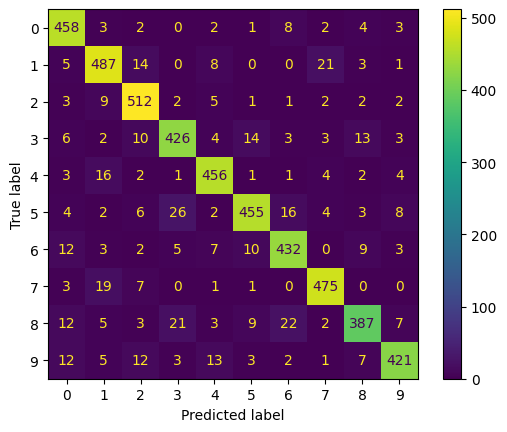

In [12]:
cm_digits = confusion_matrix(test_labels, predicted_labels)
ConfusionMatrixDisplay(confusion_matrix=cm_digits, display_labels=[0,1,2,3,4,5,6,7,8,9]).plot()

In [13]:
### hypertuning network


# input_tensor = tf.keras.Input(shape=(1024,))
# accuracy = []
# hidden_sizes = list([24,32,64,100,70,80,90,120,150,200])
# reg_l1_params = list([10e-6, 10e-5, 10e-4, 10e-3])
# for hidden_size in hidden_sizes:
#   for reg_l1_param in reg_l1_params:

#     hidden_layer_1 = tf.keras.layers.Dense(units=hidden_size, activation=tf.nn.relu, 
#                                           name = 'hidden_layer',
#                                           activity_regularizer=tf.keras.regularizers.l1(reg_l1_param))(input_tensor)

#     output_layer = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax, name = 'classification_layer')(hidden_layer_1)

#     model = tf.keras.Model(inputs=input_tensor, outputs=output_layer)
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#     history = model.fit(train_data, train_labels, epochs=10,verbose=0, batch_size=32, validation_data=(test_data, test_labels))
#     test_loss, test_acc = model.evaluate(test_data, test_labels)
#     accuracy.append({'reg_l1_param': reg_l1_param, 'hidden_size' : hidden_size, 'acc':test_acc})
#     print('reg_l1_param:', reg_l1_param, ' hidden_size:', hidden_size, ' Test accuracy:', test_acc)

#     # Plot the model architecture
#     #plot_model(model, to_file='model.png', show_shapes=True)
# sorted_list = sorted(accuracy, key=lambda k: k['acc'], reverse=True)
# print(sorted_list)



In [14]:
input_tensor = tf.keras.Input(shape=(1024,))


hidden_size = 150
reg_l1_param = 10e-4

hidden_layer_1 = tf.keras.layers.Dense(units=hidden_size, activation=tf.nn.relu, 
                                      name = 'hidden_layer',
                                      activity_regularizer=tf.keras.regularizers.l1(reg_l1_param))(input_tensor)

output_layer = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax, name = 'classification_layer')(hidden_layer_1)

model = tf.keras.Model(inputs=input_tensor, outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels, epochs=10,verbose=0, batch_size=32, validation_data=(test_data, test_labels))
test_loss, test_acc = model.evaluate(test_data, test_labels)
# accuracy.append({'reg_l1_param': reg_l1_param, 'hidden_size' : hidden_size, 'acc':test_acc})
print('reg_l1_param:', reg_l1_param, ' hidden_size:', hidden_size, ' Test accuracy:', test_acc)

# Plot the model architecture
#plot_model(model, to_file='model.png', show_shapes=True)

157/157 [==============================] - 1s 3ms/step - loss: 0.4007 - accuracy: 0.8894
reg_l1_param: 0.001  hidden_size: 150  Test accuracy: 0.8894000053405762


In [16]:
def feature_selection(num_iterations, num_features_selected):
  # input shape 
  input_shape = (1024,)

  # Initialize a list to hold the selected features
  selected_features = []

  accuracy =[]
  result = []
  for i in range(num_iterations):

      # Get the indices of the unselected features
      unselected_features = [j for j in range(input_shape[0]) if j not in selected_features]

      train_data_subset = train_data[:, unselected_features]
      print(train_data_subset.shape)
      input_tensor = tf.keras.Input(shape=(train_data_subset.shape[1],))
      hidden_size = 150
      reg_l1_param = 10e-4
      hidden_layer_1 = tf.keras.layers.Dense(units=hidden_size, activation=tf.nn.relu,
                                            name='hidden_layer',
                                            activity_regularizer=tf.keras.regularizers.l1(reg_l1_param))(input_tensor)
      output_layer = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax,
                                          name='classification_layer')(hidden_layer_1)
      model = tf.keras.Model(inputs=input_tensor, outputs=output_layer)
      model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

      history = model.fit(train_data_subset, train_labels, epochs=10, verbose=0, batch_size=32,
                          validation_data=(test_data[:, unselected_features], test_labels))
      test_loss, test_acc = model.evaluate(test_data[:, unselected_features], test_labels)

      # Get the average weights of the unselected features after the input layer
      weights = model.layers[1].get_weights()[0]
      avg_weights = np.max(weights, axis=0)

      # Select the top features based on the average weights
      selected_indices = np.argsort(avg_weights)[-num_features_selected:]
      selected_features += [unselected_features[idx] for idx in selected_indices]
      
  # Train an SVM model using the selected features
      clf.fit(train_data[:, selected_features], train_labels)
      predicted_labels = clf.predict(test_data[:, selected_features])
      accuracy.append(accuracy_score(test_labels, predicted_labels))
      result.append(accuracy_score(test_labels, predicted_labels) - (len(selected_features) * 0.00075))
  return result, accuracy


In [21]:
def analysis_plot (acc_minus_penalty, acc):
  plt.xticks(np.arange(0, len(acc_minus_penalty), 1))
  plt.yticks(np.arange(0, 1, 0.05))
  plt.plot(acc_minus_penalty, label = "accuracy minus penalty")
  plt.plot(acc, label = "accuracy")
  plt.xlabel("Iterate Number")
  plt.ylabel("score")
  plt.title("score of the svm model procedure in iterations")
  plt.legend()
  plt.show()

(5000, 1024)
157/157 [==============================] - 0s 2ms/step - loss: 0.3941 - accuracy: 0.8938
(5000, 994)
157/157 [==============================] - 0s 2ms/step - loss: 0.4020 - accuracy: 0.8880
(5000, 964)
157/157 [==============================] - 0s 2ms/step - loss: 0.4013 - accuracy: 0.8910
(5000, 934)
157/157 [==============================] - 0s 2ms/step - loss: 0.4200 - accuracy: 0.8838
(5000, 904)
157/157 [==============================] - 0s 2ms/step - loss: 0.4206 - accuracy: 0.8826
acc minus penalty:[0.5181, 0.624, 0.6969, 0.7138, 0.7232999999999999]
acc:[0.5406, 0.669, 0.7644, 0.8038, 0.8358]


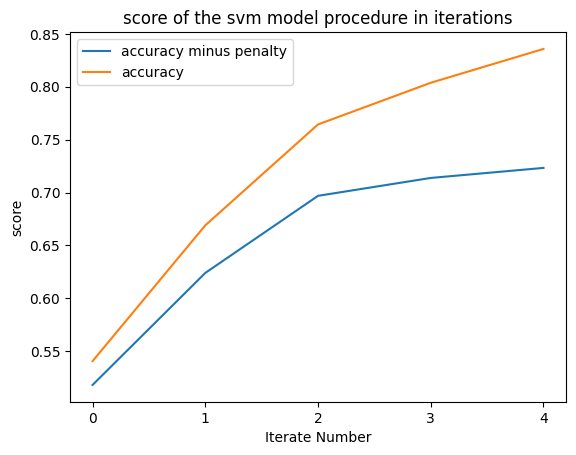

In [22]:
acc_minus_penalty, acc = feature_selection(5, 30)
print("acc minus penalty:" + str(acc_minus_penalty))
print("acc:" + str(acc))

analysis_plot (acc_minus_penalty, acc)

(5000, 1024)
157/157 [==============================] - 0s 2ms/step - loss: 0.3939 - accuracy: 0.8892
(5000, 1009)
157/157 [==============================] - 0s 2ms/step - loss: 0.3944 - accuracy: 0.8868
(5000, 994)
157/157 [==============================] - 0s 2ms/step - loss: 0.4001 - accuracy: 0.8896
(5000, 979)
157/157 [==============================] - 0s 2ms/step - loss: 0.4113 - accuracy: 0.8862
(5000, 964)
157/157 [==============================] - 0s 2ms/step - loss: 0.4093 - accuracy: 0.8892
(5000, 949)
157/157 [==============================] - 0s 2ms/step - loss: 0.4073 - accuracy: 0.8888
(5000, 934)
157/157 [==============================] - 0s 2ms/step - loss: 0.4158 - accuracy: 0.8862
(5000, 919)
157/157 [==============================] - 0s 2ms/step - loss: 0.4120 - accuracy: 0.8878
(5000, 904)
157/157 [==============================] - 0s 2ms/step - loss: 0.4142 - accuracy: 0.8840
(5000, 889)
157/157 [==============================] - 0s 2ms/step - loss: 0.4131 - accur

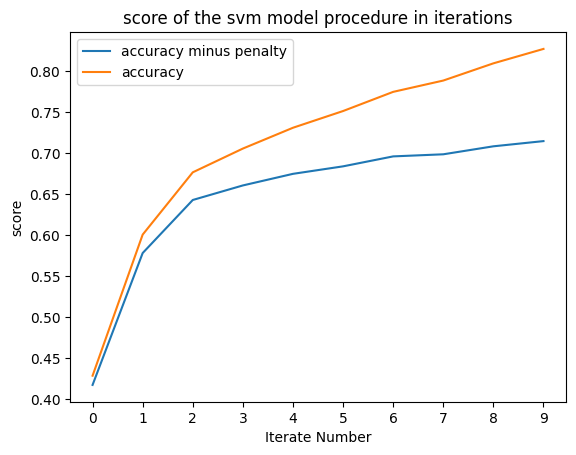

In [23]:
acc_minus_penalty, acc = feature_selection(10, 15)
print("acc_minus_penalty:" + str(acc_minus_penalty))
print("acc:" + str(acc))

analysis_plot (acc_minus_penalty, acc)

(5000, 1024)
157/157 [==============================] - 0s 2ms/step - loss: 0.3971 - accuracy: 0.8964
(5000, 1019)
157/157 [==============================] - 0s 2ms/step - loss: 0.3917 - accuracy: 0.8934
(5000, 1014)
157/157 [==============================] - 0s 2ms/step - loss: 0.3877 - accuracy: 0.8950
(5000, 1009)
157/157 [==============================] - 0s 2ms/step - loss: 0.4005 - accuracy: 0.8890
(5000, 1004)
157/157 [==============================] - 1s 3ms/step - loss: 0.4002 - accuracy: 0.8876
(5000, 999)
157/157 [==============================] - 0s 3ms/step - loss: 0.4132 - accuracy: 0.8856
(5000, 994)
157/157 [==============================] - 1s 3ms/step - loss: 0.4153 - accuracy: 0.8834
(5000, 989)
157/157 [==============================] - 0s 2ms/step - loss: 0.4069 - accuracy: 0.8888
(5000, 984)
157/157 [==============================] - 1s 3ms/step - loss: 0.3958 - accuracy: 0.8898
(5000, 979)
157/157 [==============================] - 1s 4ms/step - loss: 0.4156 - ac

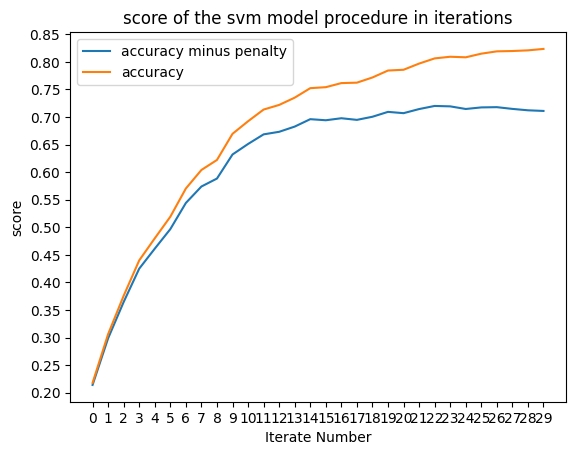

In [24]:
acc_minus_penalty, acc = feature_selection(30, 5)
print("acc_minus_penalty:" + str(acc_minus_penalty))
print("acc:" + str(acc))

analysis_plot (acc_minus_penalty, acc)

(5000, 1024)
157/157 [==============================] - 0s 3ms/step - loss: 0.3916 - accuracy: 0.8920
(5000, 984)
157/157 [==============================] - 0s 2ms/step - loss: 0.3980 - accuracy: 0.8922
(5000, 944)
157/157 [==============================] - 1s 3ms/step - loss: 0.4111 - accuracy: 0.8856
(5000, 904)
157/157 [==============================] - 0s 2ms/step - loss: 0.3972 - accuracy: 0.8898
(5000, 864)
157/157 [==============================] - 0s 2ms/step - loss: 0.4079 - accuracy: 0.8832
acc_minus_penalty:[0.6068, 0.6906000000000001, 0.7044, 0.7106, 0.6976]
acc:[0.6368, 0.7506, 0.7944, 0.8306, 0.8476]


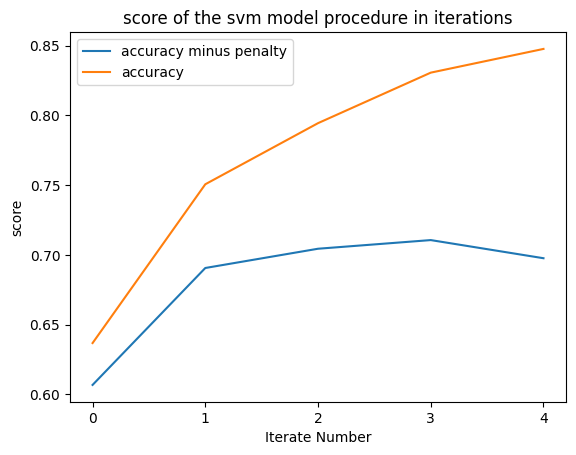

In [34]:
acc_minus_penalty, acc = feature_selection(5, 40)
print("acc_minus_penalty:" + str(acc_minus_penalty))
print("acc:" + str(acc))

analysis_plot (acc_minus_penalty, acc)

(5000, 1024)
157/157 [==============================] - 1s 3ms/step - loss: 0.3896 - accuracy: 0.8940
(5000, 1004)
157/157 [==============================] - 0s 2ms/step - loss: 0.4065 - accuracy: 0.8886
(5000, 984)
157/157 [==============================] - 1s 3ms/step - loss: 0.4060 - accuracy: 0.8892
(5000, 964)
157/157 [==============================] - 0s 2ms/step - loss: 0.4035 - accuracy: 0.8860
(5000, 944)
157/157 [==============================] - 1s 3ms/step - loss: 0.4084 - accuracy: 0.8866
(5000, 924)
157/157 [==============================] - 0s 2ms/step - loss: 0.4020 - accuracy: 0.8872
(5000, 904)
157/157 [==============================] - 0s 2ms/step - loss: 0.4143 - accuracy: 0.8852
(5000, 884)
157/157 [==============================] - 0s 2ms/step - loss: 0.4200 - accuracy: 0.8848
(5000, 864)
157/157 [==============================] - 0s 3ms/step - loss: 0.4150 - accuracy: 0.8832
(5000, 844)
157/157 [==============================] - 0s 2ms/step - loss: 0.4231 - accur

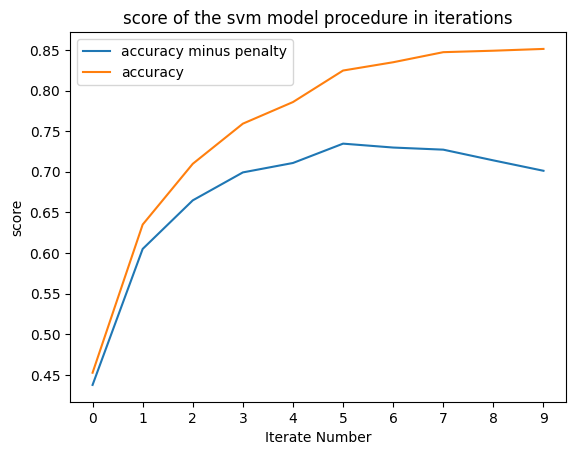

In [35]:
acc_minus_penalty, acc = feature_selection(10, 20)
print("acc_minus_penalty:" + str(acc_minus_penalty))
print("acc:" + str(acc))

analysis_plot (acc_minus_penalty, acc)

(5000, 1024)
157/157 [==============================] - 0s 2ms/step - loss: 0.4015 - accuracy: 0.8898
(5000, 994)
157/157 [==============================] - 0s 2ms/step - loss: 0.4055 - accuracy: 0.8860
(5000, 964)
157/157 [==============================] - 0s 2ms/step - loss: 0.4037 - accuracy: 0.8862
(5000, 934)
157/157 [==============================] - 0s 2ms/step - loss: 0.4107 - accuracy: 0.8860
acc_minus_penalty:[0.49889999999999995, 0.5882, 0.6813, 0.6876]
acc:[0.5214, 0.6332, 0.7488, 0.7776]


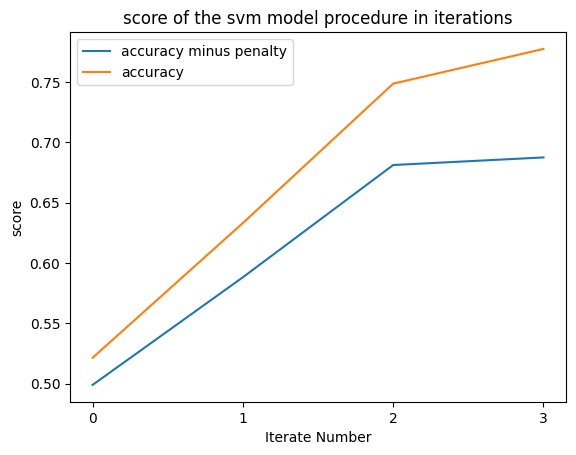

In [36]:
acc_minus_penalty, acc = feature_selection(4, 30)
print("acc_minus_penalty:" + str(acc_minus_penalty))
print("acc:" + str(acc))

analysis_plot (acc_minus_penalty, acc)

(5000, 1024)
157/157 [==============================] - 0s 2ms/step - loss: 0.4027 - accuracy: 0.8882
(5000, 1004)
157/157 [==============================] - 0s 2ms/step - loss: 0.3978 - accuracy: 0.8900
(5000, 984)
157/157 [==============================] - 0s 2ms/step - loss: 0.4063 - accuracy: 0.8860
(5000, 964)
157/157 [==============================] - 0s 2ms/step - loss: 0.4020 - accuracy: 0.8886
(5000, 944)
157/157 [==============================] - 0s 2ms/step - loss: 0.3924 - accuracy: 0.8924
acc_minus_penalty:[0.4154, 0.5287999999999999, 0.6362, 0.681, 0.7080000000000001]
acc:[0.4304, 0.5588, 0.6812, 0.741, 0.783]


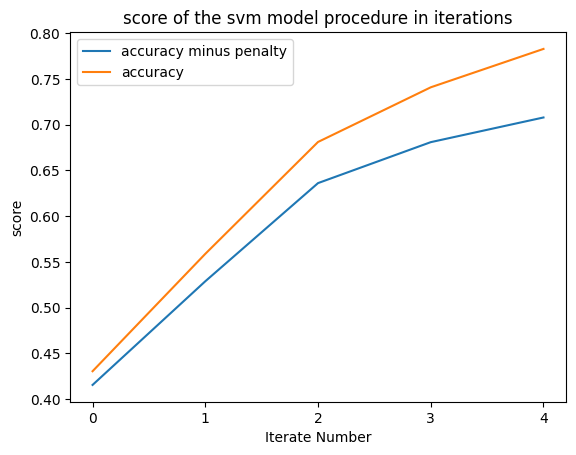

In [37]:
acc_minus_penalty, acc = feature_selection(5, 20)
print("acc_minus_penalty:" + str(acc_minus_penalty))
print("acc:" + str(acc))

analysis_plot (acc_minus_penalty, acc)

(5000, 1024)
157/157 [==============================] - 0s 2ms/step - loss: 0.4007 - accuracy: 0.8908
(5000, 1014)
157/157 [==============================] - 0s 2ms/step - loss: 0.3994 - accuracy: 0.8888
(5000, 1004)
157/157 [==============================] - 0s 2ms/step - loss: 0.3934 - accuracy: 0.8948
(5000, 994)
157/157 [==============================] - 0s 2ms/step - loss: 0.3915 - accuracy: 0.8932
(5000, 984)
157/157 [==============================] - 0s 2ms/step - loss: 0.4147 - accuracy: 0.8850
(5000, 974)
157/157 [==============================] - 0s 2ms/step - loss: 0.4023 - accuracy: 0.8920
(5000, 964)
157/157 [==============================] - 0s 2ms/step - loss: 0.4123 - accuracy: 0.8902
(5000, 954)
157/157 [==============================] - 0s 2ms/step - loss: 0.4054 - accuracy: 0.8870
(5000, 944)
157/157 [==============================] - 0s 2ms/step - loss: 0.4074 - accuracy: 0.8832
(5000, 934)
157/157 [==============================] - 1s 3ms/step - loss: 0.4186 - accu

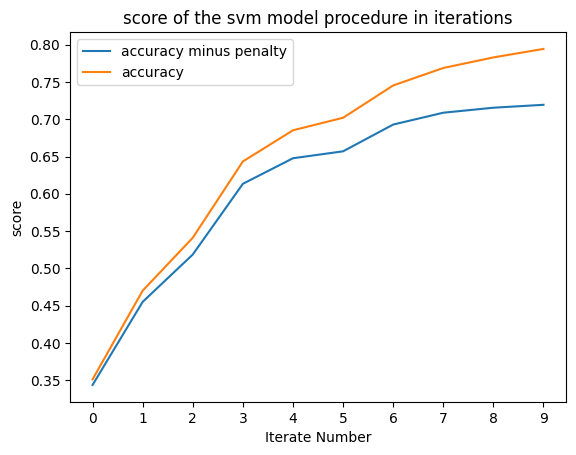

In [38]:
acc_minus_penalty, acc = feature_selection(10, 10)
print("acc_minus_penalty:" + str(acc_minus_penalty))
print("acc:" + str(acc))

analysis_plot (acc_minus_penalty, acc)

(5000, 1024)
157/157 [==============================] - 0s 3ms/step - loss: 0.3998 - accuracy: 0.8878
(5000, 1004)
157/157 [==============================] - 1s 3ms/step - loss: 0.4166 - accuracy: 0.8854
(5000, 984)
157/157 [==============================] - 0s 2ms/step - loss: 0.4061 - accuracy: 0.8880
(5000, 964)
157/157 [==============================] - 0s 2ms/step - loss: 0.4169 - accuracy: 0.8822
(5000, 944)
157/157 [==============================] - 0s 2ms/step - loss: 0.4016 - accuracy: 0.8876
(5000, 924)
157/157 [==============================] - 0s 2ms/step - loss: 0.4044 - accuracy: 0.8846
acc_minus_penalty:[0.415, 0.5846, 0.6437999999999999, 0.6838, 0.7168, 0.7212000000000001]
acc:[0.43, 0.6146, 0.6888, 0.7438, 0.7918, 0.8112]


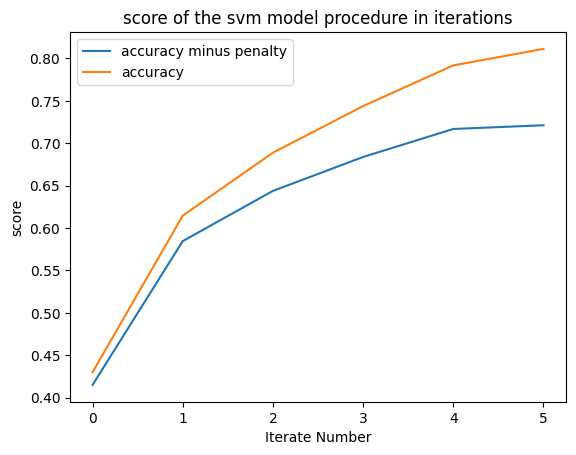

In [39]:
acc_minus_penalty, acc = feature_selection(6, 20)
print("acc_minus_penalty:" + str(acc_minus_penalty))
print("acc:" + str(acc))

analysis_plot (acc_minus_penalty, acc)

In [46]:
num_iterations = 6
num_features_selected = 20
# input shape 
input_shape = (1024,)

# Initialize a list to hold the selected features
selected_features = []

accuracy =[]
result = []
for i in range(num_iterations+1):

    # Get the indices of the unselected features
    unselected_features = [j for j in range(input_shape[0]) if j not in selected_features]

    train_data_subset = train_data[:, unselected_features]
    print(train_data_subset.shape)
    input_tensor = tf.keras.Input(shape=(train_data_subset.shape[1],))
    hidden_size = 150
    reg_l1_param = 10e-4
    hidden_layer_1 = tf.keras.layers.Dense(units=hidden_size, activation=tf.nn.relu,
                                          name='hidden_layer',
                                          activity_regularizer=tf.keras.regularizers.l1(reg_l1_param))(input_tensor)
    output_layer = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax,
                                        name='classification_layer')(hidden_layer_1)
    model = tf.keras.Model(inputs=input_tensor, outputs=output_layer)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_data_subset, train_labels, epochs=10, verbose=0, batch_size=32,
                        validation_data=(test_data[:, unselected_features], test_labels))
    test_loss, test_acc = model.evaluate(test_data[:, unselected_features], test_labels)

    # Get the average weights of the unselected features after the input layer
    weights = model.layers[1].get_weights()[0]
    avg_weights = np.max(weights, axis=0)

    # Select the top features based on the average weights
    selected_indices = np.argsort(avg_weights)[-num_features_selected:]
    selected_features += [unselected_features[idx] for idx in selected_indices]
      
  # Train an SVM model using the selected features
print(len(selected_features))
clf.fit(train_data[:, selected_features], train_labels)
predicted_labels = clf.predict(test_data[:, selected_features])
accuracy = (accuracy_score(test_labels, predicted_labels))
accuracy_minus_penalty = (accuracy_score(test_labels, predicted_labels) - (len(selected_features) * 0.00075))
print("accuracy:" + str(accuracy))
print("accuracy_minus_penalty:" + str(accuracy_minus_penalty))


(5000, 1024)
157/157 [==============================] - 0s 2ms/step - loss: 0.3980 - accuracy: 0.8902
(5000, 1004)
157/157 [==============================] - 0s 2ms/step - loss: 0.3995 - accuracy: 0.8896
(5000, 984)
157/157 [==============================] - 0s 2ms/step - loss: 0.4067 - accuracy: 0.8886
(5000, 964)
157/157 [==============================] - 0s 2ms/step - loss: 0.4115 - accuracy: 0.8864
(5000, 944)
157/157 [==============================] - 0s 2ms/step - loss: 0.4146 - accuracy: 0.8840
(5000, 924)
157/157 [==============================] - 1s 3ms/step - loss: 0.4250 - accuracy: 0.8846
(5000, 904)
157/157 [==============================] - 0s 2ms/step - loss: 0.4229 - accuracy: 0.8866
140
accuracy:0.8274
accuracy_minus_penalty:0.7224


Authors: Pouria Nazemi - Tahoora Saeedi